### Pipelines

#### Install pytorch with GPU

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print("Torch version: {}".format( torch.__version__) )
print("Is cuda available: {}".format( torch.cuda.is_available() ) )

tcmalloc: large alloc 1073750016 bytes == 0x5c20a000 @  0x7f2e7f2a42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Torch version: 0.4.0
Is cuda available: True


#### Get access to the data from google drive

> It is better to connect google drive, because data file is too big to be downloaded every time with wget, here
is the sharable link :
https://drive.google.com/drive/folders/1XHshasenGH7y1UNEoNDzwQztVP_6eQ-x?usp=sharing

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Import and install file processing requirements

In [0]:
!pip install Pillow==4.0.0


from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg
import numpy as np
import os


    100% |████████████████████████████████| 5.6MB 6.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


#### Load all Pneumonia and Normal Images and then resize them into 256 to 256 pixels

In [0]:
#  library for resizing
from skimage.transform import resize

#  positive class - Normal lung images

X_train_pos = []
mypath = "/content/drive/My Drive/chest_xray/train/NORMAL/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for im_name in onlyfiles:
  if ".jpeg" in im_name:
    img = mpimg.imread(mypath+im_name)
    img = np.array(img)
    img = resize(img, (256,256))
    X_train_pos.append(img)
    
    
    
# positive labels are one's

y_train_pos = []
for i in range(len(X_train_pos)):
  y_train_pos.append(1)
  
  
  
#  negative class - Lung images with Pneumonia

X_train_neg = []
mypath = "/content/drive/My Drive/chest_xray/train/PNEUMONIA/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for im_name in onlyfiles:
  if ".jpeg" in im_name:
    img = mpimg.imread(mypath+im_name)
    img = np.array(img)
    img = resize(img, (256,256))
    X_train_neg.append(img)

    
    
    
# negative labels are zero's

y_train_neg = []
for i in range(len(X_train_neg)):
  y_train_neg.append(0)
  
  
  
  
#  Some images has three channels, which are the duplicating the grayscale channel, 
#  so remove additional channels

for i in range(len(X_train_neg)):
  if len(X_train_neg[i].shape) > 2:
    X_train_neg[i] = X_train_neg[i].reshape(-1,256,256)[0]

    
#  Each list contains numpy arrays of with equal dimensions except first, 
#  so stack it to one numpy matrix

a = np.stack( X_train_pos, axis=0 )
b = np.stack( X_train_neg, axis=0 )
c = np.stack( y_train_pos, axis=0 )
d = np.stack( y_train_neg, axis=0 )

# X train file is concatenated positve and negative X classes
X_train = np.concatenate((a, b))
# the same with Y train file
y_train = np.concatenate((c, d))

# dereference lists which are no longer needed 
X_train_pos = None
X_train_neg = None
y_train_pos = None
y_train_neg = None

# Force garbage collector call to free memory which is no longer used
import gc
gc.collect()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0

#### Import all metrics and model selections methods and split the data into the train and test sets

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  Randomly split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


#  In order to apply linear models, we need to squeeze each datapoint to one-dimensional array
X_train = X_train.reshape(-1, 256*256)
X_test = X_test.reshape(-1, 256*256)



### Logstic Regression Classifier

In [0]:
from sklearn.metrics import f1_score

# resize to 1D array to apply linear models

X_train = X_train.reshape(-1, 256*256)
X_test = X_test.reshape(-1, 256*256)


clf = LogisticRegression()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



print(accuracy)
print(auc)
print(f1)

0.9634146341463414
0.9454320418495117
0.9299221357063404


### Ridge Regression Classifier

In [0]:
from sklearn.linear_model import Ridge
X_train = X_train.reshape(-1, 256*256)
X_test = X_test.reshape(-1, 256*256)


clf = Ridge()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred.round())
auc = roc_auc_score(y_test, y_pred.round())
print(accuracy)
print(auc)

0.9436701509872242
0.9209120262299144


### Ridge regression classifier

In [0]:

from sklearn.linear_model import Lasso

X_train = X_train.reshape(-1, 256*256)
X_test = X_test.reshape(-1, 256*256)


clf = Lasso()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred.round())
auc = roc_auc_score(y_test, y_pred.round())

print(accuracy)
print(auc)

0.7322880371660859
0.5


### Linear Discriminant Analysis Classifier (Memory error, decided to skip)

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(accuracy)
print(auc)


### Convolutional Neural Network

Import all the pytorch requirements

In [0]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

#### Hyperameters of the model

In [0]:
num_classes = 2

# Image is grayscale, so number of channels is one
channels = 1

# 256x256 pixels each image
height = 256
width = 256


In [0]:
#  Number of filters in each convolutional layer
num_filters_conv1 = 8 
kernel_size_conv1 = 4 # [height, width]
stride_conv1 = 2 # [stride_height, stride_width]

# Number of Neurons in the last fully connected layer
num_l1 = 1000
padding_conv1 = 0
   
#  Source: CNN introduction jupyter notebook ROBT 407 Course, Nazarbayev University
#  function to calculate the dimension of the image after one convolutional layer
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

### Model definition

In [0]:
# define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         out_dim = (input_dim - filter_dim + 2*padding) / stride + 1
        self.conv_1 = Conv2d(in_channels=channels,
                            out_channels=num_filters_conv1,
                            kernel_size=kernel_size_conv1,
                            stride=(2,2))
        self.pool1 = MaxPool2d(kernel_size=2, stride=2)
        self.conv_out_height = compute_conv_dim(height)
        self.conv_out_width = compute_conv_dim(width)        
        # add dropout to network
        self.dropout = Dropout2d(p=0.3)
        
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                            out_channels=num_filters_conv1*2,
                            kernel_size=kernel_size_conv1,
                            stride=stride_conv1)
        
        self.pool2 = MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv_3 = Conv2d(in_channels=num_filters_conv1*2,
#                             out_channels=num_filters_conv1*2,
#                             kernel_size=kernel_size_conv1,
#                             stride=stride_conv1)
        
#         self.pool3 = MaxPool2d(kernel_size=2, stride=2)
        
        self.l1_in_features = num_filters_conv1*2 *225
        
#         self.l1_in_features = num_filters_conv1*2 *9

#         self.l1_in_features = 2883 # 3844
        
        
        
        self.l_1 = Linear(in_features=self.l1_in_features,
                          out_features=num_l1,
                          bias=True)        
        self.l_out = Linear(in_features=num_l1, 
                            out_features=1,
                            bias=False)    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = x.view(-1, 1, 256,256)
#         x = self.pool2(x)
        x = relu(self.conv_1(x))
#         print(x.shape)
        x = self.pool1(x)
#         print(x.shape)
        x = self.pool2(relu(self.conv_2(x)))
  
#         x = self.pool3(relu(self.conv_3(x)))
#         print(x.shape)
#         print(x.shape)
        x = x.view(-1, self.l1_in_features)
#         print(x.shape)
        x = self.dropout(relu(self.l_1(x)))
#         print(x.shape)
#         x = softmax(self.l_out(x), dim=1)
        x = F.sigmoid(self.l_out(x))
#         print(x.shape)
        return x
net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.3)
  (conv_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_1): Linear(in_features=3600, out_features=1000, bias=True)
  (l_out): Linear(in_features=1000, out_features=1, bias=False)
)


### Training loop

Net:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([175])) that is different to the input size (torch.Size([175, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1722])) that is different to the input size (torch.Size([1722, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([174])) that is different to the input size (torch.Size([174, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0, train loss: 0.542511086165905, validation_loss: 0.4593226909637451
Epoch: 3, train loss: 0.12453825026750565, validation_loss: 0.11849124729633331
Epoch: 6, train loss: 0.07218730933964253, validation_loss: 0.09034895896911621
Finished Training


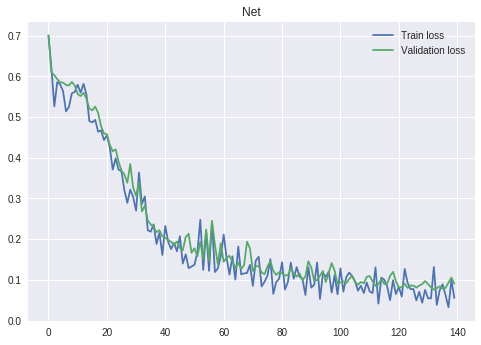

In [0]:
X_train = X_train.reshape(-1, 256, 256)
X_test = X_test.reshape(-1, 256, 256)
cv = 20
learning_rate = 0.001
num_epochs = 6
print_every = 3

from sklearn.model_selection import KFold

names = ["Net"]
nets = [Net()]
c = 1
for i in range(len(nets)):
  print("{}:".format(names[i]))
  net = nets[i]
  net.cuda()

  # lists to record loss values for plotting
  train_list = []
  val_list = []

  # Binarry Cross Entropy loss
  criterion = nn.BCELoss()

  # Opimizing with Adam, choose alpha as 0.001 for stability
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)


  for j in range(num_epochs + 1):
  #   Here KFold used for batching with the test, not for the cross validation
      kf = KFold(n_splits=cv)

      running_loss = 0.0
      for train_index, test_index in kf.split(X_train):

  #     Convert current train set to pytorch float variable 
        x = Variable(torch.from_numpy(np.array(X_train[test_index]))).float()
        y = Variable(torch.from_numpy(np.array(y_train[test_index]))).float()

#         print(x.shape)
        optimizer.zero_grad()

  #     calculate loss of the train data
        outputs = net(x.cuda())
        loss = criterion(outputs, y.cuda())

  #     calculate the loss for the validation set
        x_ = Variable(torch.from_numpy(X_test))
        x_ = x_.float()
        y_ = Variable(torch.from_numpy(y_test))
        y_ = y_.float()
        outputs_ = net(x_.cuda())
        val_loss = criterion(outputs_, y_.cuda())

  #     backward step, propagate the loss
        loss.backward()

  #     update weights 
        optimizer.step()

  #     update current super batch level loss
        running_loss += loss.item()

  #     fix current train and validation loss
        train_list.append(loss.item())
        val_list.append(val_loss.item())


      if j%print_every == 0: 
        print("Epoch: {}, train loss: {}, validation_loss: {}".format( j, running_loss/cv, val_list[-1]))

  print('Finished Training')


  import matplotlib.pyplot as plt
  plt.title(names[i])
  plt.plot(train_list, label="Train loss")
  plt.plot(val_list, label="Validation loss")
  plt.legend()
  plt.savefig('opimization.png')
  plt.show()

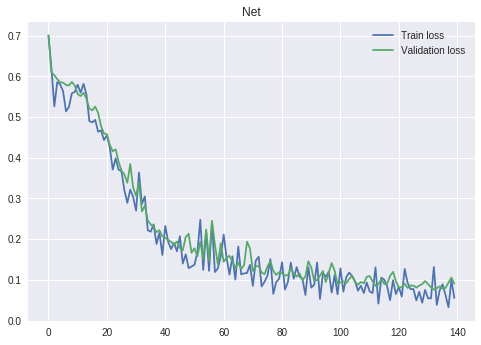

In [0]:
plt.title(names[i])
plt.plot(train_list, label="Train loss")
plt.plot(val_list, label="Validation loss")
plt.legend()
plt.savefig('opimization.png', dpi=400)
plt.show()

### Model evaluation

In [0]:
test_results = []
for i in range(len(nets)):
  
  print("{}:".format(names[i]))
  net = nets[i]
  
  
  x_test = Variable(torch.from_numpy(X_test))
  x_test = x_test.float()
  outputs = net(x_test.cuda() )
  outputs = outputs.cpu().detach().numpy()
  print('Accuracy test: {}'.format(accuracy_score(y_test, np.round(outputs ))))
  print('AUC test: {}'.format(roc_auc_score(y_test, outputs)))
  print('F1 test: {}'.format(f1_score(y_test, outputs.round()  )))
  
  test_results.append(roc_auc_score(y_test, outputs))
  
    
  x_train = Variable(torch.from_numpy(X_train))
  x_train = x_train.float()
  outputs = net(x_train.cuda() )
  outputs = outputs.cpu().detach().numpy()
  print('Accuracy train: {}'.format(accuracy_score(y_train, np.round(outputs ))))
  print('AUC train:{}'.format(roc_auc_score(y_train, outputs)))
  print('F1 test: {}'.format(f1_score(y_train,  outputs.round()  )))

Net:
Accuracy test: 0.9639953542392566
AUC test: 0.9919373289456257
F1 test: 0.9301801801801801
Accuracy train: 0.9665140240412136
AUC train:0.9948407178131738
F1 test: 0.93185789167152


## Comments:
1. Data is unbalanced 1296 positive and 3875 negative
2. Images have different sizes
3. Images were resized to 256*256 sized images
4. Logistic regression with default hyperparameters gave Accuracy of 95.4 and AUC of 93.8
5. Результаты первой нейронки  CNN - 2 layers, 3x3 kernels, 8 - 16 filters, Relu activation 
20 epochs, cv = 20, strongly overfits 
Net:

Accuracy test: 0.9636048526863085

AUC test: 0.9934756135158467

Accuracy train: 0.9910256410256411

AUC train:0.9994298025814751


6.
7. 

1
0


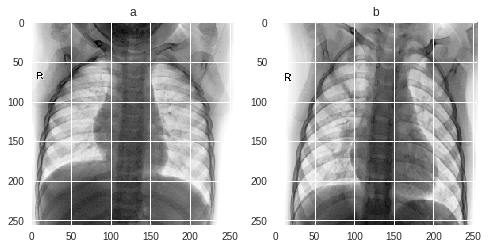

In [0]:
print(y_train[0])
print(y_train[10])

plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.title("a")
plt.subplot(1,2,2)
plt.title("b")
plt.imshow(X_train[10])
plt.savefig("Lungs.png")
plt.show()


In [0]:
AUC_list = [
0.9903,
0.9885,
0.9916,
0.9954,
0.9844,
0.9885
]
ACC_list = [
0.9610,
0.9634,
0.9657,
0.9651,
0.9378,
0.9541
]

F1_list = [
0.9246,
0.9303,
0.9353,
0.9306,
0.8742,
0.9158
]

Model_list = [
    "1 layer,3x3",
    "1 layer,4x4",
    "2 layer,3x3",
    "2 layer,4x4",
    "3 layer,3x3",
    "3 layer,4x4"
]

index_list = [1,2,3,4,5,6]

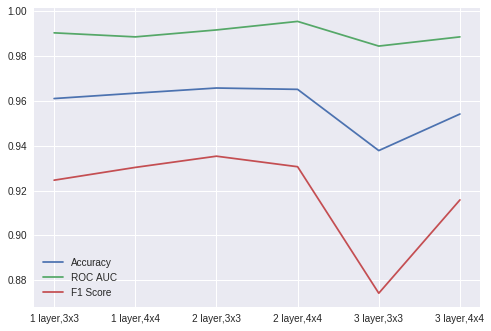

In [0]:
plt.plot(Model_list, ACC_list, label="Accuracy")
plt.plot(Model_list, AUC_list, label="ROC AUC")
plt.plot(Model_list, F1_list, label="F1 Score")

plt.legend()
plt.savefig("bar.png", dpi=400)
plt.show()

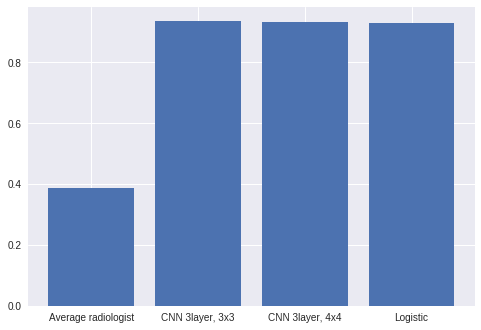

In [0]:
# ACC_list = [0.9634, 0.9657, 0.9651, ]
F1_list = [ 0.9299, 0.9353, 0.9306,0.387]
range_list = [1, 2, 3, 4]
lab = ["Logistic", "CNN 3layer, 3x3", "CNN 3layer, 4x4", "Average radiologist"]
plt.bar( lab, F1_list)
plt.savefig("f_different.png", dpi=400)
# plt.xticks(lab)
plt.show()

0


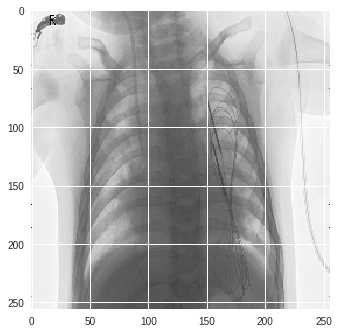

In [0]:
plt.imshow(X_train[177])
print(y_train[177])